In [23]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
from isca_tools.convection.base import lcl_metpy, convection_neutral_profile, dry_profile_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
from geocat.comp.interpolation import interp_hybrid_to_pressure
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8
ax_linewidth = plt.rcParams['axes.linewidth']

In [199]:
exp_dir = 'sqe_profile/column/day150/'
lat = 90
tau_bm = ['600', '1800', '3600', '7200']
n_exp = len(tau_bm)
# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+f'lat={lat}_tau_bm={tau_bm[0]}')
solday = namelist['two_stream_gray_rad_nml']['solday']
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

ds = [isca_tools.load_dataset(exp_dir + f"lat={lat}_tau_bm={tau_bm[i]}", decode_times=True).isel(lon=0) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(tau_bm, dims="tau_bm", name="tau_bm"))
ds = ds.load()

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [200]:
# Get info at 500hPa
pressure_ft = 500 * 100
ds['temp500'] = interp_hybrid_to_pressure(ds.temp, ds.ps, ds.pfull*0, ds.pfull/1000, new_levels=np.asarray([pressure_ft]), lev_dim='pfull')
ds['height500'] = interp_hybrid_to_pressure(ds.height, ds.ps, ds.pfull*0, ds.pfull/1000, new_levels=np.asarray([pressure_ft]), lev_dim='pfull')
ds['mse'] = moist_static_energy(ds.temp, ds.sphum, ds.height)
ds['mse_sat_500'] = moist_static_energy(ds.temp500, sphum_sat(ds.temp500, pressure_ft), ds.height500)

ds = ds.isel(plev=0, lat=0).load()

### Show diurnal cycle small at lat=90 as constant sunlight
This is to justify just considering one time for subsequent analysis.

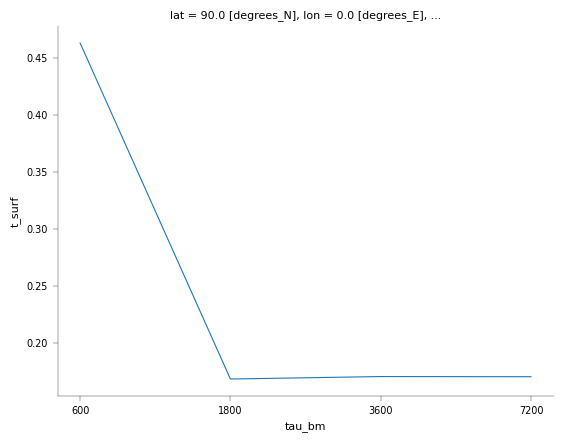

In [201]:
# Show that diurnal variation at this latitude is small hence justification for considering just one time
ds_use = ds.where(ds.time.dt.day == 25, drop=True).sel(pfull=slice(300, 1000))
(ds_use.t_surf.max(dim='time') - ds_use.t_surf.min(dim='time')).plot()
ds_use = ds_use.isel(time=1)

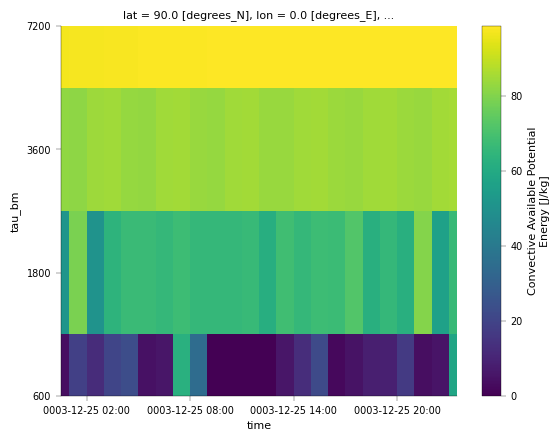

In [215]:
ds.where(ds.time.dt.day == 25, drop=True).cape.plot()

### Temperature profile relative to Convective set profile
Below, we see that for larger timescales, the actual temperature is always cooler than that desired by convection due to radiative cooling.

For small timescales, the temperature can exceed the radiatively set one, as you can get an overshoot where in a timestep, temperature is shifted to be higher than convectively set temperature. Then in next step, convection would act to reduce temperature. In reality, something like condensation may cause this temperature increase in upper troposphere, which could then push temperature above that convectively set.

In [202]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['pfull']],
                          output_core_dims=[['pfull']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    # if np.isnan(temp_lcl):
    #     return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

In [203]:
# ds_use['p_lcl'], ds_use['temp_lcl'] = lcl_metpy(ds_use.temp_2m, ds_use.sphum_2m, ds_use.ps)
# ds_use['temp_sqe'] = apply_func_vec(conv_neutral_profile, ds.pfull*100, ds_use['temp_lcl'], ds_use['p_lcl'])

ds_use['p_lcl'], ds_use['temp_lcl'] = lcl_metpy(ds_use.temp.isel(pfull=-1), ds_use.sphum.isel(pfull=-1), ds_use.pfull.isel(pfull=-1)*100)
ds_use['temp_sqe'] = apply_func_vec(conv_neutral_profile, ds.pfull*100, ds_use['temp_lcl'], ds_use['p_lcl'])

In [204]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds.pfull)), ds.pfull)
def pressure_from_k(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

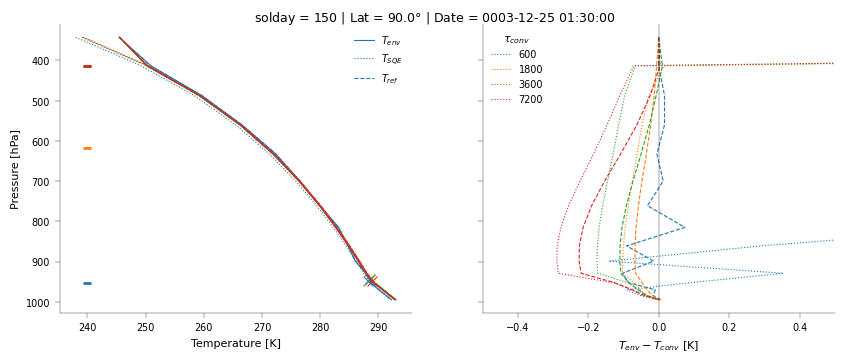

In [205]:
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
for i in range(ds_use.tau_bm.size):
    ax[0].plot(ds_use.isel(tau_bm=i).temp, ds_use.pfull, color=f'C{i}', label='$T_{env}$' if i==0 else None)
    ax[0].plot(ds_use.isel(tau_bm=i).temp_sqe, ds_use.pfull, linestyle=':', color=f'C{i}', label='$T_{SQE}$' if i==0 else None)
    ax[0].plot(ds_use.isel(tau_bm=i).t_ref, ds_use.pfull, linestyle='--', color=f'C{i}', label='$T_{ref}$' if i==0 else None)
    # ax[0].scatter(240, pressure_from_k(ds_use.isel(tau_bm=i).klcls), color=f'C{i}', lw=ax_linewidth)
    ax[0].scatter(240, pressure_from_k(ds_use.isel(tau_bm=i).klzbs), color=f'C{i}', lw=ax_linewidth, marker='_', linewidth=2, s=40)
    ax[0].scatter(ds_use.isel(tau_bm=i).temp_lcl, ds_use.isel(tau_bm=i).p_lcl/100, color=f'C{i}', marker='x', s=50)
    ax[1].plot(ds_use.isel(tau_bm=i).temp - ds_use.isel(tau_bm=i).temp_sqe, ds_use.pfull, color=f'C{i}', linestyle=':', label=tau_bm[i])
    ax[1].plot(ds_use.isel(tau_bm=i).temp - ds_use.isel(tau_bm=i).t_ref, ds_use.pfull, color=f'C{i}', linestyle='--')
ax[0].invert_yaxis()
ax[1].set_xlim(-0.5, 0.5)
ax[0].legend()
ax[1].legend(title='$\\tau_{conv}$')
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('$T_{env} - T_{conv}$ [K]')
fig.suptitle(f"solday = {solday} | Lat = {ds_use.lat:.1f}$\degree$ | Date = {ds_use.time.values}", fontsize=9, y=0.92)
plt.show()
# plt.ylim(1000, 700)
# plt.xlim(280, 294)

#### Effect on CAPE
Below, we see that as the convective timescale increases, convection is triggered more frequently because there is more CAPE (as convection does not act quick enough to destroy it). This is also reflected in moist static energy.

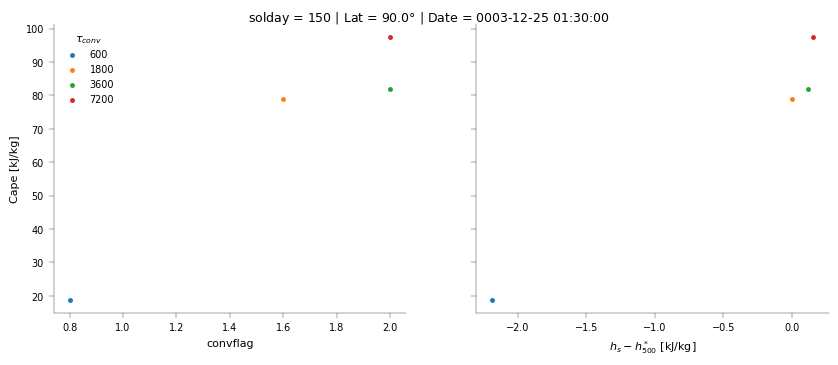

In [211]:
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
for i in range(ds_use.tau_bm.size):
    ax[0].scatter(ds_use.convflag[i], ds_use.cape[i], label=tau_bm[i])
    ax[1].scatter((ds_use.mse.isel(pfull=-1) - ds_use.mse_sat_500)[i], ds_use.cape[i], label=tau_bm[i])
ax[0].legend(title='$\\tau_{conv}$')
fig.suptitle(f"solday = {solday} | Lat = {ds_use.lat:.1f}$\degree$ | Date = {ds_use.time.values}", fontsize=9, y=0.92)
ax[0].set_ylabel('Cape [kJ/kg]')
ax[0].set_xlabel('convflag')
ax[1].set_xlabel('$h_s - h_{500}^*$ [kJ/kg]')
plt.show()

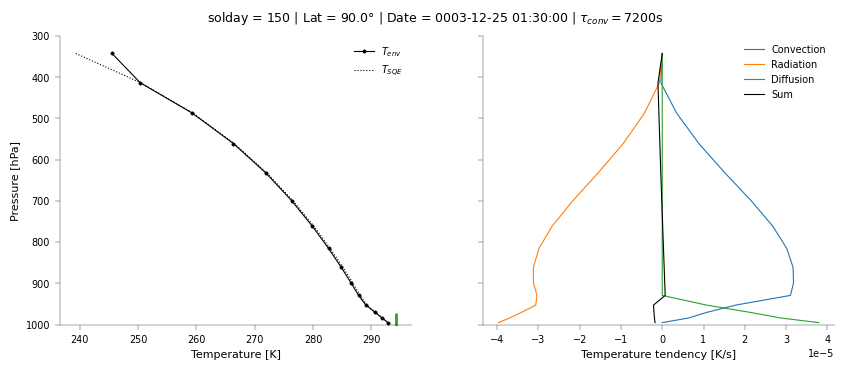

In [217]:
tau_ind_use = -1
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].plot(ds_use.temp.isel(tau_bm=tau_ind_use), ds_use.pfull, color='k', marker='o', label='$T_{env}$')
ax[0].plot(ds_use.temp_sqe.isel(tau_bm=tau_ind_use), ds_use.pfull, linestyle=':', color='k', label='$T_{SQE}$')
ax[0].scatter(ds_use.t_surf.isel(tau_bm=tau_ind_use), 1000, color='C2', marker='|', s=300, lw=2)
ax[0].invert_yaxis()
ax[1].plot(ds_use.dt_tg_convection.isel(tau_bm=tau_ind_use), ds_use.pfull, color='C0', label='Convection')
ax[1].plot(ds_use.tdt_rad.isel(tau_bm=tau_ind_use), ds_use.pfull, color='C1', label='Radiation')
# ax[1].plot(ds_use.tdt_solar, ds_use.pfull, color='C1', linestyle=':', label='Radiation (just solar)')
ax[1].plot(ds_use.dt_tg_diffusion.isel(tau_bm=tau_ind_use), ds_use.pfull, color='C2', label='Diffusion')
ax[1].plot((ds_use.dt_tg_diffusion + ds_use.tdt_rad + ds_use.dt_tg_convection).isel(tau_bm=tau_ind_use), ds_use.pfull, color='k', label='Sum')
ax[0].set_ylim(1000, 300)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature tendency [K/s]')
fig.suptitle(f"solday = {solday} | Lat = {ds_use.lat:.1f}$\degree$ | Date = {ds_use.time.values} | "+"$\\tau_{conv} = $" + f"{tau_bm[tau_ind_use]}s",
             fontsize=9, y=0.95)
plt.show()